## 3 Transformation Tests

> These are just transformation tests for each kept feature after feature selection to confirm:
> - types of imputation/transformations to be used
> - which feature will receive single/multiple treatments

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox, skew
from sklearn.preprocessing import PowerTransformer

pd.pandas.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Life_Expectancy_Final.csv')
print(df.shape)
df.head()

(2928, 16)


,Country,Year,Status,Adult_Mortality,Infant_Deaths,Alcohol,Bmi,Polio,Total_Expenditure,Diphtheria,Hiv/Aids,Gdp,Thinness_1to19,Income_Composition,Schooling,Life_Expectancy
0,Afghanistan,2015,Developing,263.0,62,0.01,19.1,6.0,8.16,65.0,0.1,584.259210,17.2,0.479,10.1,65.0
1,Afghanistan,2014,Developing,271.0,64,0.01,18.6,58.0,8.18,62.0,0.1,612.696514,17.5,0.476,10.0,59.9
2,Afghanistan,2013,Developing,268.0,66,0.01,18.1,62.0,8.13,64.0,0.1,631.744976,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,272.0,69,0.01,17.6,67.0,8.52,67.0,0.1,669.959000,17.9,0.463,9.8,59.5
4,Afghanistan,2011,Developing,275.0,71,0.01,17.2,68.0,7.87,68.0,0.1,63.537231,18.2,0.454,9.5,59.2


In [6]:
missing = [var for var in df.columns if df[var].isnull().sum() > 0]
df[missing].isnull().mean().sort_values(ascending=False)

Gdp                   0.151298
Total_Expenditure     0.077186
Alcohol               0.065915
Income_Composition    0.054645
Schooling             0.054645
Bmi                   0.010929
Thinness_1to19        0.010929
Diphtheria            0.006489
Polio                 0.006489
dtype: float64

> The amount of missing values are mild, so transformer tests first to determine the type of transformation will be conducted, in the final pipeline all features are imputed first with mean/median depending on the existence of outliers before being transformed and scaled.

In [7]:
powerTrans = PowerTransformer(method='yeo-johnson')

In [33]:
tmp = df.copy()

In [ ]:
def winsorize(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return lower, upper

In [56]:
def plot_transforms_outlier(variants, feature):
    plt.figure(figsize=(8, 4))
    for i, (data, title) in enumerate(variants):
        plt.subplot(2, 2, i + 1)
        sns.boxplot(x=data)
        plt.title(title)
        plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

## Numerical

In [83]:
skewness = df.skew(numeric_only=True).sort_values(ascending=False)
skewness

Infant_Deaths         9.771044
Hiv/Aids              5.386623
Gdp                   3.202781
Thinness_1to19        1.710626
Adult_Mortality       1.174369
Alcohol               0.587276
Total_Expenditure     0.577233
Year                  0.000000
Bmi                  -0.230559
Schooling            -0.583884
Life_Expectancy      -0.638605
Income_Composition   -1.142142
Diphtheria           -2.072601
Polio                -2.097958
dtype: float64

### Target - `YeoJohnson Transform` (Transform Only)

> Target is for transformation only. If it has outliers, winsorizing/clipping it would modify the true values and remove the ground truth.

In [34]:
tmp[['Life_Expectancy']] = powerTrans.fit_transform(tmp[['Life_Expectancy']])
print(f'Original Skew: {df["Life_Expectancy"].skew()}\nAfter Yeo-Johnson: {tmp["Life_Expectancy"].skew()}')

Original Skew: -0.6386047358773552
After Yeo-Johnson: -0.10604246262580315


> Transformation method for `Target` was already determined in EDA notebook

### Adult_Mortality - `BoxCox Transform` (Transform + Winsorize)

In [35]:
adult_mortality = tmp['Adult_Mortality']
adult_boxcox, _ = boxcox(adult_mortality)
print(f'Original Skew: {skew(adult_mortality)}\nAfter BoxCox: {skew(adult_boxcox)}')

Original Skew: 1.1737677783478573
After BoxCox: -0.08420787382317432


> Boxplots for winsorized and original version for Adult_Mortality already sampled in `EDA notebook`

### Infant_Deaths - `YeoJohnson Transform` (Transform + Winsorize)

In [ ]:
infant_death = tmp['Infant_Deaths']
infant_death_log = np.log1p(infant_death)
infant_death_sqrt = np.sqrt(infant_death)
infant_death_yeo = powerTrans.fit_transform(tmp[['Infant_Deaths']]).flatten()
print(f'Original Skew: {infant_death.skew()}\nLog: {skew(infant_death_log)}\nSqrt: {skew(infant_death_sqrt)}\nYeo: {skew(infant_death_yeo)}')

Original Skew: 9.771044493066025
Log: 0.6975065450016457
Sqrt: 3.5809308741331423
Yeo: 0.17322997179686883


In [54]:
winsor_infant_death = winsorize(pd.DataFrame({'Infant_Deaths_Yeo': infant_death_yeo}), 'Infant_Deaths_Yeo')
tmp_infant_death = np.clip(infant_death_yeo, winsor_infant_death[0], winsor_infant_death[1])
tmp_infant_death

array([1.36006936, 1.37147056, 1.38244594, ..., 0.99954719, 0.99954719,
       0.98175565], shape=(2928,))

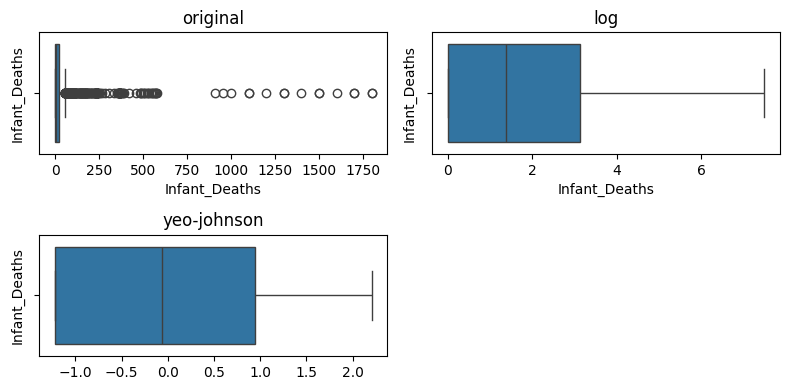

In [57]:
plot_transforms_outlier([
    (df['Infant_Deaths'], 'original'),
    (infant_death_log, 'log'),
    (tmp_infant_death, 'yeo-johnson')
], 'Infant_Deaths')

### Alcohol - `YeoJohnson Transform` (Transform only)

In [91]:
alcohol = tmp['Alcohol'].dropna()
alcohol_log = np.log1p(alcohol)
alcohol_sqrt = np.sqrt(alcohol)
alcohol_yeo = powerTrans.fit_transform(alcohol.to_frame()).flatten()
alcohol_boxcox, _ = boxcox(alcohol)
print(f'Original Skew: {alcohol.skew()}\nLog: {skew(alcohol_log)}\nSqrt: {skew(alcohol_sqrt)}\nYeo: {skew(alcohol_yeo)}\nBoxCox: {skew(alcohol_boxcox)}')

Original Skew: 0.5872759823338337
Log: -0.27995582439107314
Sqrt: -0.11979803360316608
Yeo: -0.08589765118380314
BoxCox: -0.3740016701689468


### BMI - no transformations needed (besides Scaling)

In [ ]:
# missing, left skewed, no outliers, all positive
bmi = tmp['Bmi'].dropna()
bmi_log = np.log(bmi)
bmi_square = np.power(bmi, 2)
bmi_yeo = powerTrans.fit_transform(bmi.to_frame()).flatten()
print(f'Original Skew: {bmi.skew()}\nLog: {skew(bmi_log)}\nSquare: {skew(bmi_square)}\nYeo: {skew(bmi_yeo)}')

Original Skew: -0.23055870673126674
Log: -1.4000322474194193
Square: 0.2659727295733653
Yeo: -0.31018724044852664


### Polio - `Reflect + Log Transform` (transform only)

In [116]:
polio = tmp['Polio'].dropna()
polio_reflect = polio.max() + 1 - polio
polio_log_non_reflect = np.log(polio)
polio_log_reflect = np.log(polio_reflect)
polio_square = np.power(polio, 2)
polio_cube = np.power(polio, 3)
polio_yeo = powerTrans.fit_transform(polio.to_frame()).flatten()
print(f'Original Skew: {polio.skew()}\nLog (non-reflect): {skew(polio_log_non_reflect)}\nLog (reflect): {skew(polio_log_reflect)}\nSquare: {skew(polio_square)}\nCube:{skew(polio_cube)}\nYeo: {skew(polio_yeo)}')

Original Skew: -2.097958050876243
Log (non-reflect): -3.27372429424499
Log (reflect): 0.1045405557569941
Square: -1.348622061757707
Cube:-0.9544737377335307
Yeo: -1.0228240642246225


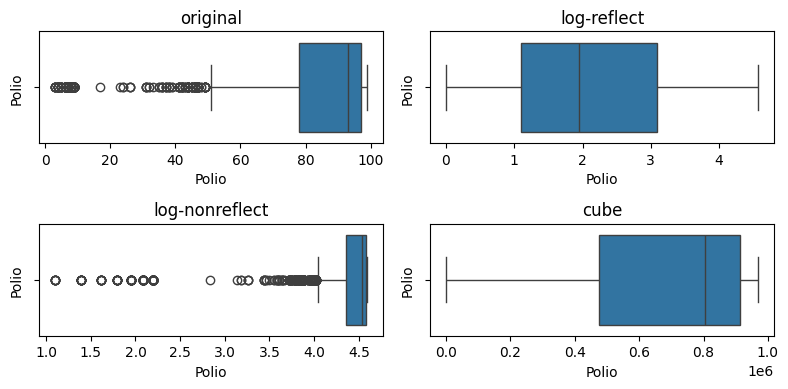

In [121]:
plot_transforms_outlier([
    (df['Polio'], 'original'),
    (polio_log_reflect, 'log-reflect'),
    (polio_log_non_reflect, 'log-nonreflect'),
    (polio_cube, 'cube')
], 'Polio')

### Total_Expenditure - `YeoJohnson Transform` (transform + winsor)

In [126]:
total_exp= tmp['Total_Expenditure'].dropna()
total_exp_log = np.log1p(total_exp)
total_exp_sqrt = np.sqrt(total_exp)
total_exp_boxcox, _ = boxcox(total_exp)
total_exp_yeo = powerTrans.fit_transform(total_exp.to_frame()).flatten()
print(f'Original Skew: {total_exp.skew()}\nLog: {skew(total_exp_log)}\nSqrt: {skew(total_exp_sqrt)}\nBoxCox: {skew(total_exp_boxcox)}\nYeo: {skew(total_exp_yeo)}')

Original Skew: 0.5772333235968544
Log: -0.6366071722816218
Sqrt: -0.16841541239470456
BoxCox: 0.003207736445409766
Yeo: 0.00305574052857833


In [131]:
winsor_total_exp = winsorize(pd.DataFrame({'Total_Exp_Yeo': total_exp_yeo}), 'Total_Exp_Yeo')
tmp_total_exp = np.clip(total_exp_yeo, winsor_total_exp[0], winsor_total_exp[1])

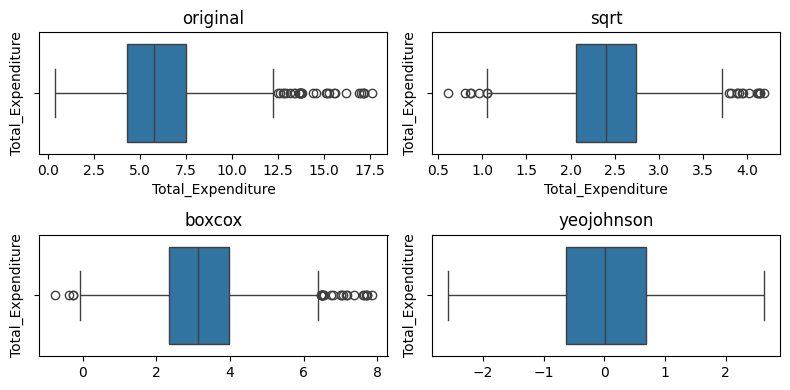

In [132]:
plot_transforms_outlier([
    (df['Total_Expenditure'], 'original'),
    (total_exp_sqrt, 'sqrt'),
    (total_exp_boxcox, 'boxcox') ,
    (tmp_total_exp, 'yeojohnson')
], 'Total_Expenditure')

### Diphtheria - `Reflect + Log Transform` (transform only)

In [138]:
diphther = tmp['Diphtheria'].dropna()
diphther_reflect = diphther.max() + 1 - diphther
diphther_log_non_reflect = np.log(diphther)
diphther_log_reflect = np.log(diphther_reflect)
diphther_square = np.power(diphther, 2)
diphther_cube = np.power(diphther, 3)
diphther_yeo = powerTrans.fit_transform(diphther.to_frame()).flatten()
print(f'Original Skew: {diphther.skew()}\nLog (non-reflect): {skew(diphther_log_non_reflect)}\nLog (reflect): {skew(diphther_log_reflect)}\nSquare: {skew(diphther_square)}\nCube:{skew(diphther_cube)}\nYeo: {skew(diphther_yeo)}')

Original Skew: -2.072601052317206
Log (non-reflect): -3.2084619615110674
Log (reflect): 0.10884318863645735
Square: -1.366055743895695
Cube:-0.9722944996670797
Yeo: -1.0387790458702832


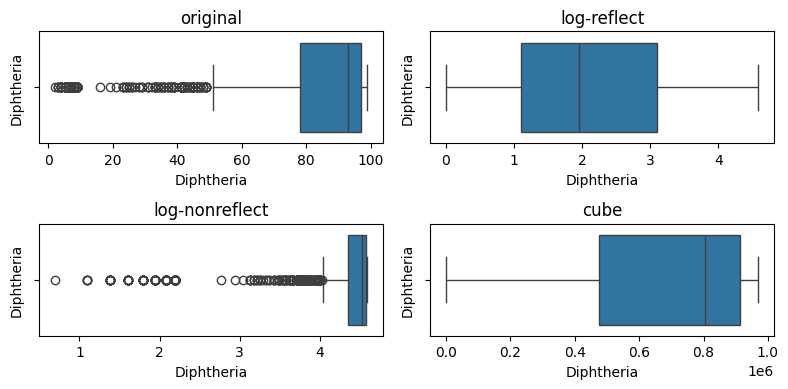

In [139]:
plot_transforms_outlier([
    (df['Diphtheria'], 'original'),
    (diphther_log_reflect, 'log-reflect'),
    (diphther_log_non_reflect, 'log-nonreflect'),
    (diphther_cube, 'cube')
], 'Diphtheria')

### HIV/AIDS - `Box-Cox Transform` (transform only)

In [147]:
hiv_aids = tmp['Hiv/Aids']
#diphther_reflect = diphther.max() + 1 - diphther
#diphther_log_reflect = np.log(diphther_reflect)
hiv_aids_log = np.log(hiv_aids)
hiv_aids_sqrt = np.sqrt(hiv_aids)
hiv_aids_boxcox, _ = boxcox(hiv_aids)
hiv_aids_yeo = powerTrans.fit_transform(hiv_aids.to_frame()).flatten()
print(f'Original Skew: {hiv_aids.skew()}\nLog: {skew(hiv_aids_log)}\nSqrt: {skew(hiv_aids_sqrt)}\nBoxcox: {skew(hiv_aids_boxcox)}\nYeo: {skew(hiv_aids_yeo)}')

Original Skew: 5.386623166297798
Log: 1.2776646837720835
Sqrt: 2.84864047976718
Boxcox: 0.6754909736253697
Yeo: 0.9650711306661278


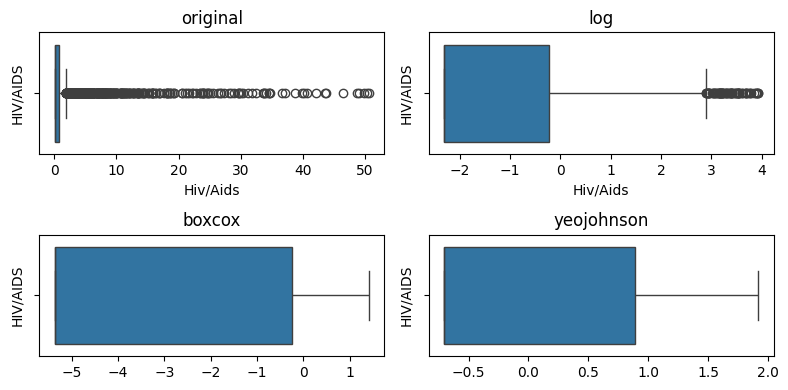

In [149]:
plot_transforms_outlier([
    (df['Hiv/Aids'], 'original'),
    (hiv_aids_log, 'log'),
    (hiv_aids_boxcox, 'boxcox'),
    (hiv_aids_yeo, 'yeojohnson')
], 'HIV/AIDS')

### GDP - `YeoJohnson Transform` (transform+winsorize)

In [156]:
gdp = tmp['Gdp'].dropna()
#diphther_reflect = diphther.max() + 1 - diphther
#diphther_log_reflect = np.log(diphther_reflect)
gdp_log = np.log(gdp)
gdp_sqrt = np.sqrt(gdp)
gdp_boxcox, _ = boxcox(gdp)
gdp_yeo = powerTrans.fit_transform(gdp.to_frame()).flatten()
print(f'Original Skew: {gdp.skew()}\nLog: {skew(gdp_log)}\nSqrt: {skew(gdp_sqrt)}\nBoxcox: {skew(gdp_boxcox)}\nYeo: {skew(gdp_yeo)}')

Original Skew: 3.202781401465919
Log: -0.1574636887291638
Sqrt: 1.7074968728417845
Boxcox: -0.008245836423203519
Yeo: -0.007939301908380126


In [160]:
winsor_gdp = winsorize(pd.DataFrame({'Gdp_Yeo': gdp_yeo}), 'Gdp_Yeo')
tmp_gdp = np.clip(gdp_yeo, winsor_gdp[0], winsor_gdp[1])

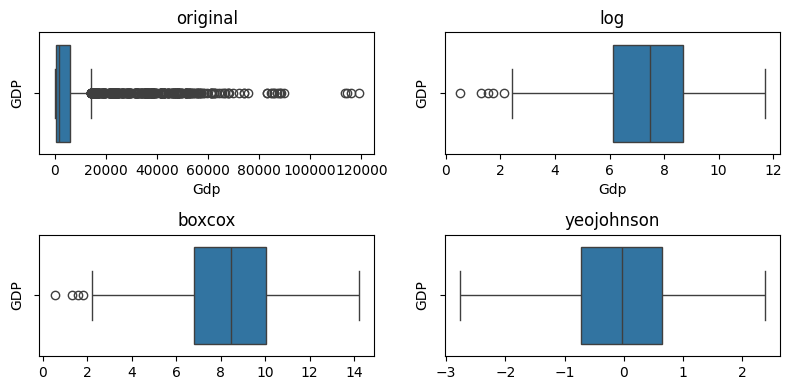

In [161]:
plot_transforms_outlier([
    (df['Gdp'], 'original'),
    (gdp_log, 'log'),
    (gdp_boxcox, 'boxcox'),
    (tmp_gdp, 'yeojohnson')
], 'GDP')

### Thinness_1to19 - `YeoJohnson Transform` (transform only)

In [168]:
thin1_19 = tmp['Thinness_1to19'].dropna()
#diphther_reflect = diphther.max() + 1 - diphther
#diphther_log_reflect = np.log(diphther_reflect)
thin1_19_log = np.log1p(thin1_19)
thin1_19_sqrt = np.sqrt(thin1_19)
thin1_19_boxcox, _ = boxcox(thin1_19)
thin1_19_yeo = powerTrans.fit_transform(thin1_19.to_frame()).flatten()
print(f'Original Skew: {thin1_19.skew()}\nLog: {skew(thin1_19_log)}\nSqrt: {skew(thin1_19_sqrt)}\nBoxcox: {skew(thin1_19_boxcox)}\nYeo: {skew(thin1_19_yeo)}')

Original Skew: 1.7106260135748141
Log: 0.14199428470062217
Sqrt: 0.6143345990521797
Boxcox: -0.03282354112860895
Yeo: 0.020767427039416725


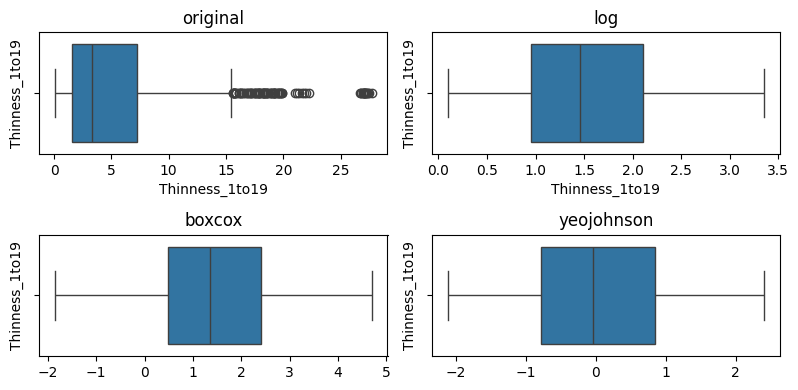

In [169]:
plot_transforms_outlier([
    (df['Thinness_1to19'], 'original'),
    (thin1_19_log, 'log'),
    (thin1_19_boxcox, 'boxcox'),
    (thin1_19_yeo, 'yeojohnson')
], 'Thinness_1to19')

### Income_Composition - `Square Transform` (transform only)

In [176]:
income_comp = tmp['Income_Composition'].dropna()
income_comp_reflect = income_comp.max() + 1 - income_comp
income_comp_log_reflect = np.log1p(income_comp_reflect)
#income_comp_log_non_reflect = np.log(income_comp)
income_comp_square = np.power(income_comp, 2)
income_comp_cube = np.power(income_comp, 3)
income_comp_yeo = powerTrans.fit_transform(income_comp.to_frame()).flatten()
print(f'Original Skew: {income_comp.skew()}\nLog (reflect): {skew(income_comp_log_reflect)}\nSquare: {skew(income_comp_square)}\nCube:{skew(income_comp_cube)}\nYeo: {skew(income_comp_yeo)}')

Original Skew: -1.1421419528521795
Log (reflect): 0.8838881235822026
Square: -0.09431045210505183
Cube:0.36884482610873964
Yeo: -0.1514452764417437


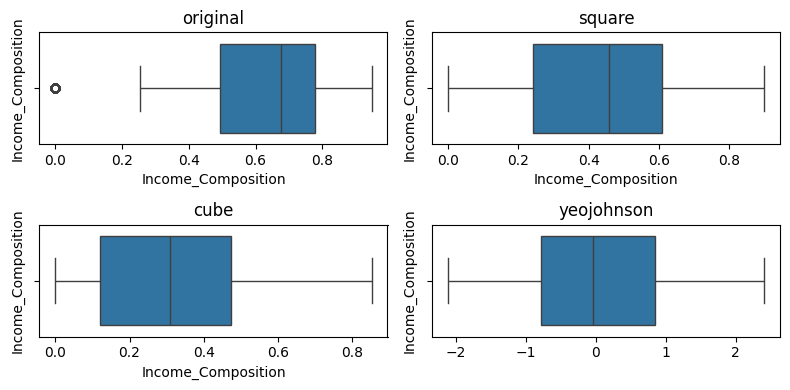

In [177]:
plot_transforms_outlier([
    (df['Income_Composition'], 'original'),
    (income_comp_square, 'square'),
    (income_comp_cube, 'cube'),
    (thin1_19_yeo, 'yeojohnson')
], 'Income_Composition')

### Schooling - `YeoJohnson Transform` (transform+winsorize)

In [186]:
schooling = tmp['Schooling'].dropna()
schooling_reflect = schooling.max() + 1 - schooling
schooling_log_reflect = np.log1p(schooling_reflect)
#schooling_log_non_reflect = np.log(schooling)
schooling_square = np.power(schooling, 2)
schooling_cube = np.power(schooling, 3)
schooling_yeo = powerTrans.fit_transform(schooling.to_frame()).flatten()
print(f'Original Skew: {schooling.skew()}\nLog (reflect): {skew(schooling_log_reflect)}\nSquare: {skew(schooling_square)}\nCube:{skew(schooling_cube)}\nYeo: {skew(schooling_yeo)}')

Original Skew: -0.5838842686144311
Log (reflect): -0.6952861464330929
Square: 0.398968538291751
Cube:1.094306488545055
Yeo: -0.058895590079400345


In [188]:
winsor_schooling = winsorize(pd.DataFrame({'Schooling_Yeo': schooling_yeo}), 'Schooling_Yeo')
tmp_schooling = np.clip(schooling_yeo, winsor_schooling[0], winsor_schooling[1])

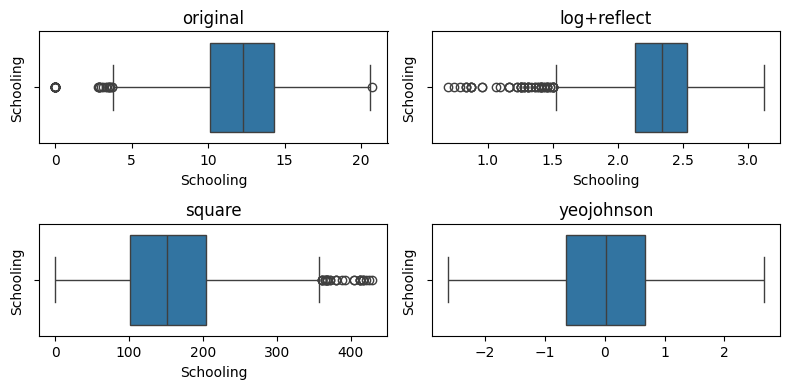

In [189]:
plot_transforms_outlier([
    (df['Schooling'], 'original'),
    (schooling_log_reflect, 'log+reflect'),
    (schooling_square, 'square'),
    (tmp_schooling, 'yeojohnson')
], 'Schooling')

## Categorical

#### `Country` - Leave One Out Encoding

In [206]:
country_freq = df['Country'].value_counts()
print(f'Countries with 16 counts: {len(country_freq[country_freq==16])}')
print(f'Unique countries in original dataset: {len(df["Country"].unique())}')

Countries with 16 counts: 183
Unique countries in original dataset: 183


> One-Hot Encoding is not advisable for this column since it has 183 unique values. Using One-Hot encoding will produce sparse matrix which potentially causes suboptimal performance, and compute inefficiency.

> Using Frequency Encoding is also not appropriate as all of the countries appear 16 times and this will render the `Country` column without variability.

> `Leave One Out Encoding` is one of the viable options. This calculates the mean of the target column for each country as a group but excludes the current row. This will introduce variability while avoiding leakage if done properly

#### `Status` - One Hot Encoding

In [207]:
df['Status'].unique()

array(['Developing', 'Developed'], dtype=object)

> One-Hot Encoding is the appropriate transformation for this column. LabelEncoding is for target labels being predicted. [Docs Reference](https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets)